In [1]:
!pip install delu rtdl_revisiting_models

Looking in indexes: https://nexus.isb/repository/pypiorg-pypi-proxy/simple, https://nexus.isb/repository/deml-prod-pypi-hosted/simple


In [2]:
!pip install torch torchvision torchaudio

Looking in indexes: https://nexus.isb/repository/pypiorg-pypi-proxy/simple, https://nexus.isb/repository/deml-prod-pypi-hosted/simple


In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import delu
from rtdl_revisiting_models import FTTransformer

from tqdm.std import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from functools import partial
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 500)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### === Готовим данные для модели ===

In [5]:
df = pd.read_csv('iar_hse_data.csv')
df.head()

y = df[['target']]
X = df.drop(columns=['target'])

In [6]:
X_cat = X.select_dtypes(include=['object'])

X_cat = X_cat.apply(LabelEncoder().fit_transform)

X_float = X.select_dtypes(include=['float'])
X_int_float = X.select_dtypes(include=['int64']).astype(np.float32)
X_float = pd.concat([X_float, X_int_float], axis=1)
X_float = X_float.astype(np.float32)

float_features_cnt = X_float.shape[1]
cat_features_card = [X_cat[x].nunique() for x in X_cat.columns]

y = y.astype('float')

In [7]:
X_float = X_float.to_numpy()
X_cat = X_cat.to_numpy()
y = y.to_numpy()
y = y[:, 0]

In [8]:
n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_idx = np.arange(0, train_end)
val_idx = np.arange(train_end, val_end)
test_idx = np.arange(val_end, n)

In [9]:
data = {
    'train' : {'x_float':X_float[train_idx], 'x_cat':X_cat[train_idx], 'y':y[train_idx]},
    'val' : {'x_float':X_float[val_idx], 'x_cat':X_cat[val_idx], 'y':y[val_idx]},
    'test' : {'x_float':X_float[test_idx], 'x_cat':X_cat[test_idx], 'y':y[test_idx]}
}

In [10]:
preprocessing = sklearn.preprocessing.StandardScaler().fit(data['train']['x_float'])

for object in data:
    data[object]['x_float'] = preprocessing.transform(data[object]['x_float'])

In [11]:
tensors = {
    object: {k: torch.as_tensor(v, device=device) for k, v in data[object].items()} for object in data
}

### === Модель FT-Transformer ===

In [12]:
model = FTTransformer(
    n_cont_features=float_features_cnt,
    cat_cardinalities=cat_features_card,
    d_out=1,
    **FTTransformer.get_default_kwargs(),
).to(device)
optimizer = model.make_default_optimizer()

In [13]:
def apply_model(batch):
    return model(batch['x_float'], batch['x_cat']).squeeze(-1)

In [14]:
pos_weight = 5
loss_func = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(pos_weight))

In [15]:
def evaluate(part, eval_batch_size, threshold=0.85):
    model.eval()
    with torch.inference_mode():
        y_pred = (
            torch.cat(
                [
                    apply_model(batch) for batch in delu.iter_batches(tensors[part], eval_batch_size)
                ]
            )
            .cpu()
        )
        y_true = tensors[part]['y'].cpu().numpy()

        y_pred = torch.sigmoid(y_pred).numpy()
        test_y_pred = y_pred
        y_pred = np.where(y_pred>=threshold, 1, 0)
        score = sklearn.metrics.roc_auc_score(y_true, test_y_pred)
        precision = sklearn.metrics.precision_score(y_true, y_pred)
        recall = sklearn.metrics.recall_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
    return score, precision, recall, cm

In [16]:
n_epochs = 50
patience = 100

eval_batch_size = 512
batch_size = 512
epoch_size = math.ceil(len(train_idx) / batch_size)
timer = delu.tools.Timer()
early_stopping = delu.tools.EarlyStopping(patience, mode='max')

print(f"Device: {device}")
print("-" * 88 + "\n")
timer.run()
for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(tensors['train'], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_func(apply_model(batch), batch['y'])
        loss.backward()
        optimizer.step()

    val_score, val_precision, val_recall, prob_val = evaluate('val', eval_batch_size)
    print(f"Rocauc: (val) {val_score:.4f} [time] {timer}")
    print(f"Precision: (val) {val_precision:.4f} [time] {timer}")
    print(f"Recall: (val) {val_recall:.4f} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    print()

Device: cpu
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 411/411 [00:36<00:00, 11.38it/s]


Rocauc: (val) 0.7821 [time] 0:00:38.702407
Precision: (val) 0.5463 [time] 0:00:38.702603
Recall: (val) 0.1113 [time] 0:00:38.702616



Epoch 1: 100%|██████████| 411/411 [00:35<00:00, 11.44it/s]


Rocauc: (val) 0.7878 [time] 0:01:16.543197
Precision: (val) 0.5378 [time] 0:01:16.543282
Recall: (val) 0.1492 [time] 0:01:16.543294



Epoch 2: 100%|██████████| 411/411 [00:35<00:00, 11.45it/s]


Rocauc: (val) 0.7890 [time] 0:01:54.411860
Precision: (val) 0.5460 [time] 0:01:54.411959
Recall: (val) 0.1441 [time] 0:01:54.411973



Epoch 3: 100%|██████████| 411/411 [00:36<00:00, 11.21it/s]


Rocauc: (val) 0.7920 [time] 0:02:32.987569
Precision: (val) 0.5425 [time] 0:02:32.987664
Recall: (val) 0.1550 [time] 0:02:32.987677



Epoch 4: 100%|██████████| 411/411 [00:36<00:00, 11.41it/s]


Rocauc: (val) 0.7930 [time] 0:03:11.479319
Precision: (val) 0.5939 [time] 0:03:11.479412
Recall: (val) 0.0923 [time] 0:03:11.479425



Epoch 5: 100%|██████████| 411/411 [00:36<00:00, 11.40it/s]


Rocauc: (val) 0.7953 [time] 0:03:49.437014
Precision: (val) 0.6110 [time] 0:03:49.437096
Recall: (val) 0.0726 [time] 0:03:49.437108



Epoch 6: 100%|██████████| 411/411 [00:34<00:00, 11.87it/s]


Rocauc: (val) 0.7938 [time] 0:04:25.812076
Precision: (val) 0.5552 [time] 0:04:25.812158
Recall: (val) 0.1320 [time] 0:04:25.812170



Epoch 7: 100%|██████████| 411/411 [00:34<00:00, 11.89it/s]


Rocauc: (val) 0.7966 [time] 0:05:02.239385
Precision: (val) 0.6397 [time] 0:05:02.239473
Recall: (val) 0.0713 [time] 0:05:02.239485



Epoch 8: 100%|██████████| 411/411 [00:35<00:00, 11.69it/s]


Rocauc: (val) 0.7980 [time] 0:05:39.854377
Precision: (val) 0.6225 [time] 0:05:39.854461
Recall: (val) 0.1033 [time] 0:05:39.854474



Epoch 9: 100%|██████████| 411/411 [00:35<00:00, 11.70it/s]


Rocauc: (val) 0.7929 [time] 0:06:17.306251
Precision: (val) 0.5855 [time] 0:06:17.306362
Recall: (val) 0.1112 [time] 0:06:17.306379



Epoch 10: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8006 [time] 0:06:54.228005
Precision: (val) 0.6106 [time] 0:06:54.228085
Recall: (val) 0.1286 [time] 0:06:54.228097



Epoch 11: 100%|██████████| 411/411 [00:34<00:00, 11.76it/s]


Rocauc: (val) 0.8008 [time] 0:07:31.110714
Precision: (val) 0.5970 [time] 0:07:31.110795
Recall: (val) 0.1105 [time] 0:07:31.110807



Epoch 12: 100%|██████████| 411/411 [00:34<00:00, 11.81it/s]


Rocauc: (val) 0.8009 [time] 0:08:07.803470
Precision: (val) 0.6141 [time] 0:08:07.803553
Recall: (val) 0.1310 [time] 0:08:07.803565



Epoch 13: 100%|██████████| 411/411 [00:35<00:00, 11.61it/s]


Rocauc: (val) 0.8028 [time] 0:08:45.265871
Precision: (val) 0.6225 [time] 0:08:45.265963
Recall: (val) 0.1417 [time] 0:08:45.265976



Epoch 14: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8023 [time] 0:09:22.628636
Precision: (val) 0.6209 [time] 0:09:22.628718
Recall: (val) 0.1343 [time] 0:09:22.628730



Epoch 15: 100%|██████████| 411/411 [00:35<00:00, 11.65it/s]


Rocauc: (val) 0.8031 [time] 0:09:59.835496
Precision: (val) 0.6138 [time] 0:09:59.835582
Recall: (val) 0.1353 [time] 0:09:59.835594



Epoch 16: 100%|██████████| 411/411 [00:35<00:00, 11.66it/s]


Rocauc: (val) 0.8014 [time] 0:10:36.976719
Precision: (val) 0.6130 [time] 0:10:36.976801
Recall: (val) 0.1374 [time] 0:10:36.976813



Epoch 17: 100%|██████████| 411/411 [00:35<00:00, 11.69it/s]


Rocauc: (val) 0.7999 [time] 0:11:14.029778
Precision: (val) 0.6020 [time] 0:11:14.029860
Recall: (val) 0.1312 [time] 0:11:14.029872



Epoch 18: 100%|██████████| 411/411 [00:36<00:00, 11.35it/s]


Rocauc: (val) 0.8053 [time] 0:11:52.277321
Precision: (val) 0.5889 [time] 0:11:52.277405
Recall: (val) 0.1640 [time] 0:11:52.277417



Epoch 19: 100%|██████████| 411/411 [00:35<00:00, 11.45it/s]


Rocauc: (val) 0.8053 [time] 0:12:30.095350
Precision: (val) 0.6009 [time] 0:12:30.095428
Recall: (val) 0.1563 [time] 0:12:30.095440



Epoch 20: 100%|██████████| 411/411 [00:34<00:00, 11.75it/s]


Rocauc: (val) 0.8024 [time] 0:13:06.966645
Precision: (val) 0.5816 [time] 0:13:06.966726
Recall: (val) 0.1812 [time] 0:13:06.966738



Epoch 21: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8043 [time] 0:13:43.882501
Precision: (val) 0.6277 [time] 0:13:43.882584
Recall: (val) 0.1391 [time] 0:13:43.882595



Epoch 22: 100%|██████████| 411/411 [00:35<00:00, 11.66it/s]


Rocauc: (val) 0.8043 [time] 0:14:21.200449
Precision: (val) 0.6338 [time] 0:14:21.200532
Recall: (val) 0.1087 [time] 0:14:21.200544



Epoch 23: 100%|██████████| 411/411 [00:35<00:00, 11.43it/s]


Rocauc: (val) 0.8044 [time] 0:14:59.511246
Precision: (val) 0.6599 [time] 0:14:59.511327
Recall: (val) 0.1171 [time] 0:14:59.511339



Epoch 24: 100%|██████████| 411/411 [00:35<00:00, 11.65it/s]


Rocauc: (val) 0.8056 [time] 0:15:36.699749
Precision: (val) 0.6181 [time] 0:15:36.699833
Recall: (val) 0.1468 [time] 0:15:36.699845



Epoch 25: 100%|██████████| 411/411 [00:35<00:00, 11.73it/s]


Rocauc: (val) 0.8051 [time] 0:16:13.580392
Precision: (val) 0.6180 [time] 0:16:13.580474
Recall: (val) 0.1546 [time] 0:16:13.580487



Epoch 26: 100%|██████████| 411/411 [00:35<00:00, 11.58it/s]


Rocauc: (val) 0.8027 [time] 0:16:50.960934
Precision: (val) 0.6393 [time] 0:16:50.961019
Recall: (val) 0.1340 [time] 0:16:50.961031



Epoch 27: 100%|██████████| 411/411 [00:35<00:00, 11.47it/s]


Rocauc: (val) 0.8053 [time] 0:17:29.108503
Precision: (val) 0.5961 [time] 0:17:29.108587
Recall: (val) 0.1791 [time] 0:17:29.108599



Epoch 28: 100%|██████████| 411/411 [00:36<00:00, 11.33it/s]


Rocauc: (val) 0.8051 [time] 0:18:07.268591
Precision: (val) 0.5705 [time] 0:18:07.268673
Recall: (val) 0.1963 [time] 0:18:07.268685



Epoch 29: 100%|██████████| 411/411 [00:35<00:00, 11.63it/s]


Rocauc: (val) 0.8004 [time] 0:18:44.472701
Precision: (val) 0.6176 [time] 0:18:44.472785
Recall: (val) 0.1425 [time] 0:18:44.472797



Epoch 30: 100%|██████████| 411/411 [00:35<00:00, 11.70it/s]


Rocauc: (val) 0.8025 [time] 0:19:21.366128
Precision: (val) 0.6222 [time] 0:19:21.366210
Recall: (val) 0.1461 [time] 0:19:21.366223



Epoch 31: 100%|██████████| 411/411 [00:35<00:00, 11.64it/s]


Rocauc: (val) 0.7996 [time] 0:19:58.685019
Precision: (val) 0.5897 [time] 0:19:58.685102
Recall: (val) 0.1779 [time] 0:19:58.685114



Epoch 32: 100%|██████████| 411/411 [00:36<00:00, 11.35it/s]


Rocauc: (val) 0.8039 [time] 0:20:36.914714
Precision: (val) 0.6567 [time] 0:20:36.914797
Recall: (val) 0.1264 [time] 0:20:36.914810



Epoch 33: 100%|██████████| 411/411 [00:35<00:00, 11.45it/s]


Rocauc: (val) 0.8039 [time] 0:21:14.712811
Precision: (val) 0.6007 [time] 0:21:14.712889
Recall: (val) 0.1668 [time] 0:21:14.712909



Epoch 34: 100%|██████████| 411/411 [00:35<00:00, 11.57it/s]


Rocauc: (val) 0.8062 [time] 0:21:52.057374
Precision: (val) 0.6232 [time] 0:21:52.057456
Recall: (val) 0.1597 [time] 0:21:52.057469



Epoch 35: 100%|██████████| 411/411 [00:35<00:00, 11.62it/s]


Rocauc: (val) 0.8039 [time] 0:22:29.351948
Precision: (val) 0.6035 [time] 0:22:29.352033
Recall: (val) 0.1683 [time] 0:22:29.352045



Epoch 36: 100%|██████████| 411/411 [00:35<00:00, 11.49it/s]


Rocauc: (val) 0.8055 [time] 0:23:07.319750
Precision: (val) 0.6056 [time] 0:23:07.319833
Recall: (val) 0.1730 [time] 0:23:07.319844



Epoch 37: 100%|██████████| 411/411 [00:35<00:00, 11.42it/s]


Rocauc: (val) 0.8032 [time] 0:23:45.157797
Precision: (val) 0.6464 [time] 0:23:45.157882
Recall: (val) 0.1340 [time] 0:23:45.157894



Epoch 38: 100%|██████████| 411/411 [00:35<00:00, 11.71it/s]


Rocauc: (val) 0.8042 [time] 0:24:22.148147
Precision: (val) 0.6102 [time] 0:24:22.148230
Recall: (val) 0.1630 [time] 0:24:22.148243



Epoch 39: 100%|██████████| 411/411 [00:35<00:00, 11.65it/s]


Rocauc: (val) 0.8037 [time] 0:24:59.274277
Precision: (val) 0.6063 [time] 0:24:59.274359
Recall: (val) 0.1768 [time] 0:24:59.274371



Epoch 40: 100%|██████████| 411/411 [00:35<00:00, 11.63it/s]


Rocauc: (val) 0.8045 [time] 0:25:36.739398
Precision: (val) 0.6118 [time] 0:25:36.739480
Recall: (val) 0.1678 [time] 0:25:36.739493



Epoch 41: 100%|██████████| 411/411 [00:35<00:00, 11.65it/s]


Rocauc: (val) 0.8037 [time] 0:26:14.010363
Precision: (val) 0.6497 [time] 0:26:14.010447
Recall: (val) 0.1338 [time] 0:26:14.010459



Epoch 42: 100%|██████████| 411/411 [00:36<00:00, 11.41it/s]


Rocauc: (val) 0.8040 [time] 0:26:51.945172
Precision: (val) 0.6156 [time] 0:26:51.945255
Recall: (val) 0.1568 [time] 0:26:51.945268



Epoch 43: 100%|██████████| 411/411 [00:35<00:00, 11.74it/s]


Rocauc: (val) 0.7997 [time] 0:27:28.838036
Precision: (val) 0.6339 [time] 0:27:28.838122
Recall: (val) 0.1289 [time] 0:27:28.838135



Epoch 44: 100%|██████████| 411/411 [00:35<00:00, 11.57it/s]


Rocauc: (val) 0.8030 [time] 0:28:06.172872
Precision: (val) 0.6113 [time] 0:28:06.172963
Recall: (val) 0.1581 [time] 0:28:06.172975



Epoch 45: 100%|██████████| 411/411 [00:35<00:00, 11.59it/s]


Rocauc: (val) 0.8030 [time] 0:28:43.912198
Precision: (val) 0.5908 [time] 0:28:43.912283
Recall: (val) 0.1797 [time] 0:28:43.912295



Epoch 46: 100%|██████████| 411/411 [00:35<00:00, 11.52it/s]


Rocauc: (val) 0.8040 [time] 0:29:21.448149
Precision: (val) 0.6012 [time] 0:29:21.448231
Recall: (val) 0.1701 [time] 0:29:21.448243



Epoch 47: 100%|██████████| 411/411 [00:35<00:00, 11.64it/s]


Rocauc: (val) 0.8040 [time] 0:29:58.694236
Precision: (val) 0.6162 [time] 0:29:58.694319
Recall: (val) 0.1601 [time] 0:29:58.694332



Epoch 48: 100%|██████████| 411/411 [00:35<00:00, 11.62it/s]


Rocauc: (val) 0.8025 [time] 0:30:35.941695
Precision: (val) 0.6075 [time] 0:30:35.941778
Recall: (val) 0.1640 [time] 0:30:35.941790



Epoch 49: 100%|██████████| 411/411 [00:35<00:00, 11.47it/s]


Rocauc: (val) 0.8018 [time] 0:31:13.814073
Precision: (val) 0.5894 [time] 0:31:13.814159
Recall: (val) 0.1930 [time] 0:31:13.814171



In [17]:
test_score, test_precision, test_recall, prob_test= evaluate('test', eval_batch_size)
print(f"Rocauc: (test) {test_score:.4f}")
print(f"Precision: (test) {test_precision:.4f}")
print(f"Recall: (test) {test_recall:.4f}")

Rocauc: (test) 0.8060
Precision: (test) 0.5706
Recall: (test) 0.1823


### === Наилучший порог по графику ===

In [18]:
def plot_precision_recall_curve(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 100)
    precisions = []
    recalls = []
    f1s = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1s, label='F1-score')
    plt.xlabel('Порог вероятности')
    plt.ylabel('Значение метрики')
    plt.title('Зависимость Precision / Recall / F1 от порога')
    plt.legend()
    plt.grid(True)
    plt.show()

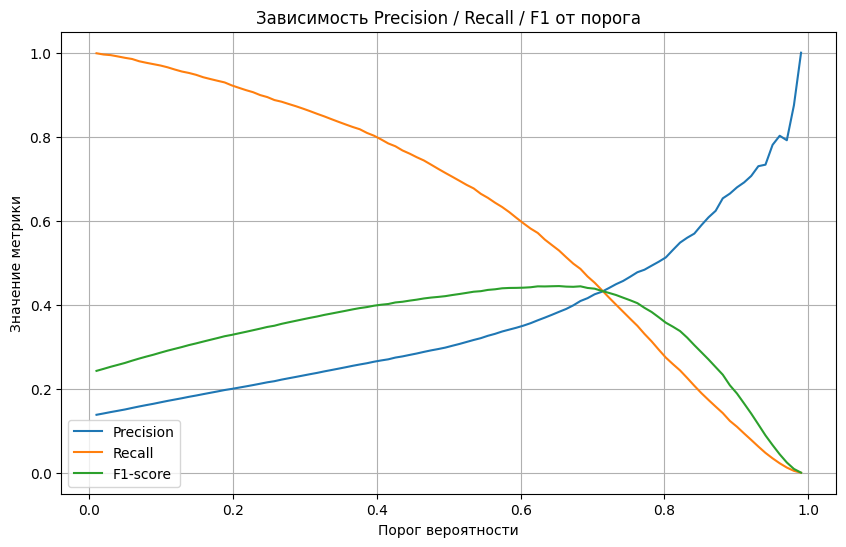

In [19]:
model.eval()
with torch.no_grad():
    val_logits = model(tensors['val']['x_float'], tensors['val']['x_cat'])
    val_proba = torch.sigmoid(val_logits).cpu().numpy()
    val_true = tensors['val']['y'].cpu().numpy()

plot_precision_recall_curve(val_true, val_proba)

###### Считаю наилучшим трешхолдом =0.85 , тк важнее немного пожертвовать precision, чтобы вырос recall, и при этом доля false positive решений не была заоблачной

### === Оценка качества на тесте с подходящим трешхолдом ===

In [42]:
def evaluate_on_test(model, tensors, threshold):
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(tensors['test']['x_float'], tensors['test']['x_cat'])).cpu().numpy()
    y_true = tensors['test']['y'].cpu().numpy()
    y_pred = (probs >= threshold).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, probs)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nФинальные метрики на тесте при threshold = {threshold:.2f}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("Confusion Matrix:\n", cm)
    return probs, y_true

In [43]:
test_proba, y_true = evaluate_on_test(model, tensors, threshold=0.85)


Финальные метрики на тесте при threshold = 0.85:
Precision: 0.5706
Recall:    0.1823
ROC AUC:   0.8060
Confusion Matrix:
 [[38798   748]
 [ 4460   994]]


In [44]:
def flow_cut(y_prob, threshold):
    return (y_prob >= threshold).mean()

In [45]:
print(f"Flow cut with best threshold: {flow_cut(test_proba, 0.85):.4f}")

Flow cut with best threshold: 0.0387


### Метрики,если срез в 4%

In [58]:
def get_threshold_for_top_percent(y_proba, top_percent=0.04):
    k = int(len(y_proba) * top_percent)
    sorted_proba = np.sort(y_proba, axis=0)
    return sorted_proba[-k]

In [59]:
threshold_4pct = get_threshold_for_top_percent(test_proba, top_percent=0.04)
y_pred_top4 = (test_proba >= threshold_4pct[0]).astype(int)

#метрики в этом срезе:
precision = precision_score(y_true, y_pred_top4)
recall = recall_score(y_true, y_pred_top4)
stream_cut = (y_pred_top4 == 1).mean()

print(f"Threshold @ top 4%: {threshold_4pct[0]:.4f}")
print(f"Precision@4%: {precision:.4f}")
print(f"Recall@4%:    {recall:.4f}")
print(f"Отсечено:     {stream_cut*100:.2f}% заявок")

Threshold @ top 4%: 0.8475
Precision@4%: 0.5689
Recall@4%:    0.1878
Отсечено:     4.00% заявок


### === Важность фичей ===

In [60]:
def permutation_importance(model, tensors, feature_names=None, part='val'):
    model.eval()

    x_float = tensors[part]['x_float'].clone()
    x_cat = tensors[part]['x_cat'].clone()
    y_true = tensors[part]['y'].cpu().numpy()

    with torch.no_grad():
        base_preds = torch.sigmoid(model(x_float, x_cat)).cpu().numpy()
    baseline_auc = roc_auc_score(y_true, base_preds)

    importances = []
    names = []

    #перемешиваем числовые признаки
    for i in range(x_float.shape[1]):
        x_float_perm = x_float.clone()
        x_float_perm[:, i] = x_float_perm[torch.randperm(len(x_float_perm)), i]
        with torch.no_grad():
            preds = torch.sigmoid(model(x_float_perm, x_cat)).cpu().numpy()
        auc = roc_auc_score(y_true, preds)
        importances.append(baseline_auc - auc)
        if feature_names:
            names.append(feature_names['float'][i])
        else:
            names.append(f'float_{i}')

    #перемешиваем категориальные признаки
    for i in range(x_cat.shape[1]):
        x_cat_perm = x_cat.clone()
        x_cat_perm[:, i] = x_cat_perm[torch.randperm(len(x_cat_perm)), i]
        with torch.no_grad():
            preds = torch.sigmoid(model(x_float, x_cat_perm)).cpu().numpy()
        auc = roc_auc_score(y_true, preds)
        importances.append(baseline_auc - auc)
        if feature_names:
            names.append(feature_names['cat'][i])
        else:
            names.append(f'cat_{i}')

    return importances, names

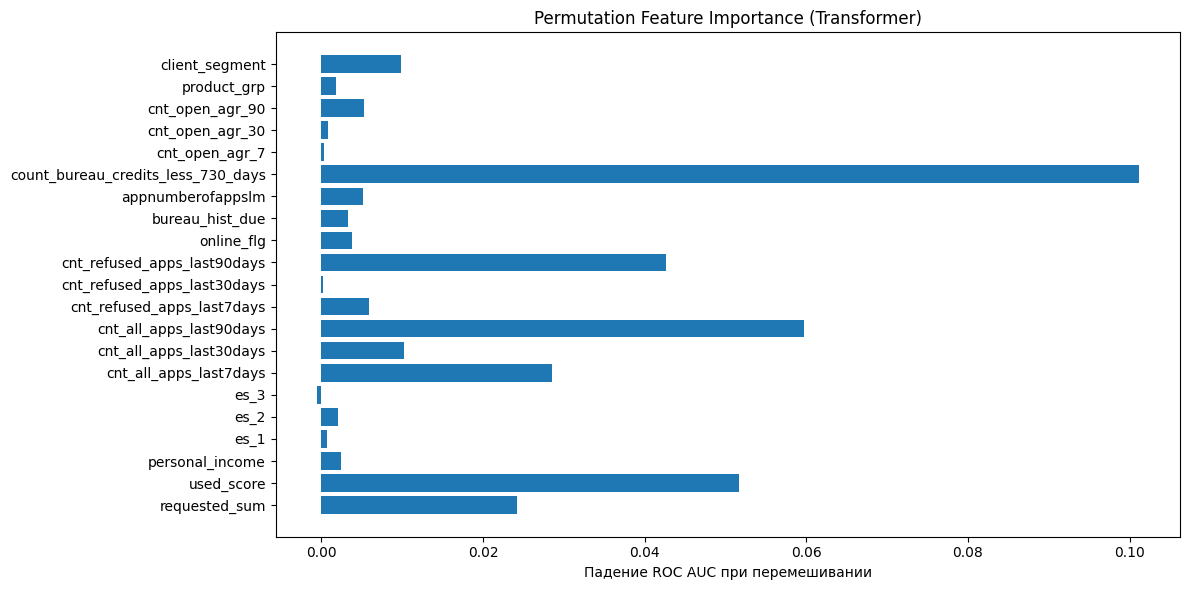

In [62]:
X_cat_df = X.select_dtypes(include=['object'])
X_float_df = X.select_dtypes(include=['float'])
X_int_float_df = X.select_dtypes(include=['int64']).astype(np.float32)
X_float_df = pd.concat([X_float_df, X_int_float_df], axis=1)

feature_names = {
    'float': list(X_float_df.columns),
    'cat': list(X_cat_df.columns),
}

importances, names = permutation_importance(model, tensors, feature_names=feature_names)

plt.figure(figsize=(12, 6))
plt.barh(names, importances)
plt.title("Permutation Feature Importance (Transformer)")
plt.xlabel("Падение ROC AUC при перемешивании")
plt.tight_layout()
plt.show()